# 04. PyTorch Custom Datasets Video Notebook

We've used some datasets with PyTorch before.

But how do you get your own data into PyTorch?

One of the ways to do so is via: custom datasets.

## Domain libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

**Resources:**
* Book version of the course materials for 04: https://www.learnpytorch.io/04_pytorch_custom_datasets/
* Ground truth version of notebook 04: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb 

In [1]:
import torch 
from torch import nn 

# Note: PyToch 1.10.0+ is required for this course
torch.__version__ 

'2.3.0'

In [5]:
# Setup device-agnostic code
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"


print(f"Using device: {device}")

Using device: mps


## 1. Get data 

Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing).

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.

In [6]:
import requests
import zipfile                 
from pathlib import Path             

# Setup path to a data folder 
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# if the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory already exists... skipping download")
else:
    print(f"{image_path} does not exist, create one ...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, strea and sushi data 
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, suhsi data...")
  f.write(request.content)
  
  
# Unzip pizza, steak, sushi data 
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak and sushi data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, create one ...
Unzipping pizza, steak and sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [7]:
import os 
def walk_through_dir(dir_path):
    """Walks through dir_path returning its contents"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    

In [8]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [9]:
# Setup train and testing paths 
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir 

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing and image

Let's write some code to:
1. Get all of the image paths 
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem` 
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata

In [10]:
image_path 

PosixPath('data/pizza_steak_sushi')

Random image path: data/pizza_steak_sushi/train/pizza/218711.jpg
Image class: pizza
Image heigh: 512
Image width: 382
Type of img: <class 'PIL.JpegImagePlugin.JpegImageFile'>


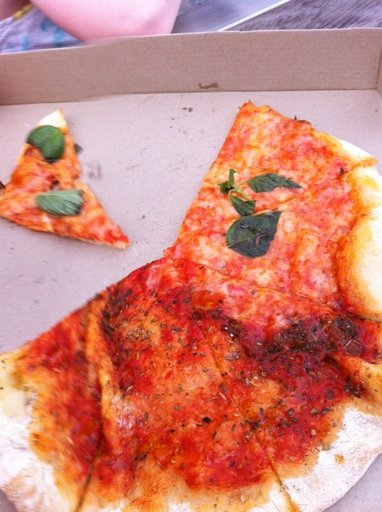

In [19]:
import random 
from PIL import Image 

# Set seed
# random.seed(42)

# 1.Get all image paths 
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path 
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the dir where the image is stored)
image_class = random_image_path.parent.stem 

# 4. Open image 
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image heigh: {img.height}")
print(f"Image width: {img.width}")
print(f"Type of img: {type(img)}")
img 

(-0.5, 381.5, 511.5, -0.5)

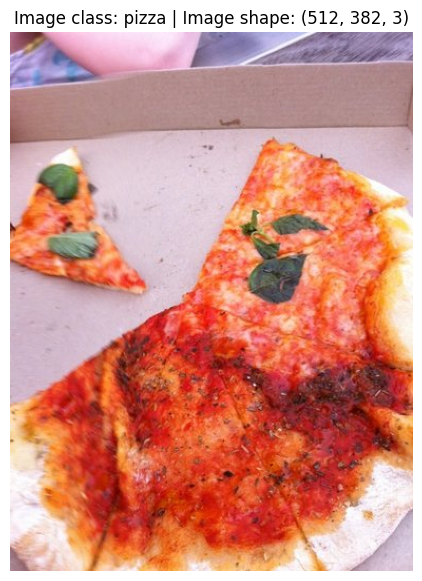

In [22]:
import numpy as np           
import matplotlib.pyplot as plt              

# Turn the image into an arrray 
img_as_array = np.asarray(img)

# Plot the image with matplotlib 
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}")
plt.axis(False)


In [23]:
img_as_array

array([[[181, 119, 144],
        [176, 114, 139],
        [170, 106, 132],
        ...,
        [134, 114, 151],
        [137, 117, 154],
        [149, 129, 166]],

       [[179, 117, 142],
        [175, 113, 138],
        [170, 106, 132],
        ...,
        [142, 122, 159],
        [144, 124, 161],
        [153, 133, 170]],

       [[176, 112, 138],
        [173, 109, 135],
        [170, 104, 131],
        ...,
        [138, 120, 158],
        [142, 124, 162],
        [148, 130, 168]],

       ...,

       [[173, 135, 148],
        [171, 133, 146],
        [167, 129, 140],
        ...,
        [215, 194, 209],
        [217, 196, 211],
        [215, 194, 209]],

       [[176, 136, 147],
        [174, 134, 145],
        [171, 131, 142],
        ...,
        [215, 194, 209],
        [217, 196, 211],
        [215, 194, 209]],

       [[176, 136, 147],
        [175, 135, 146],
        [172, 132, 143],
        ...,
        [217, 196, 211],
        [219, 198, 213],
        [218, 197, 212]]

## 3. Transforming data 

Before we can use our image data with PyTorch:
    1. Turn your target data into tensors (in our case, numerical representation of our images)
    2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.Dataloader`, we'll call these `Dataset` and `DataLoader`



In [24]:
import torch 
from torch.utils.data import DataLoader 
from torchvision import datasets, transforms 


### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation - https://pytorch.org/vision/stable/transforms.html 

In [30]:
# Write a tranform for image 
data_transform = transforms.Compose([
    # Resize our image to 64*64 
    transforms.Resize(size=(64,64)),
    # Flip the image randomly on the horizontal 
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the iamge into a torch.Tensor 
    transforms.ToTensor()
])

In [33]:
data_transform(img).shape

torch.Size([3, 64, 64])

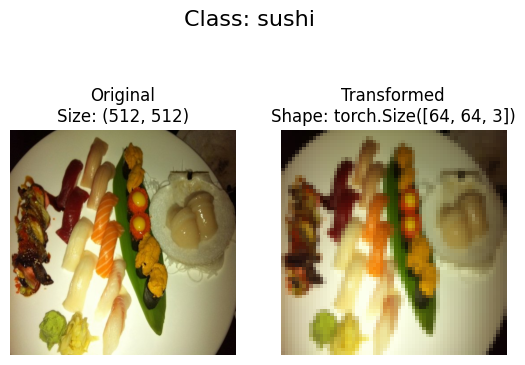

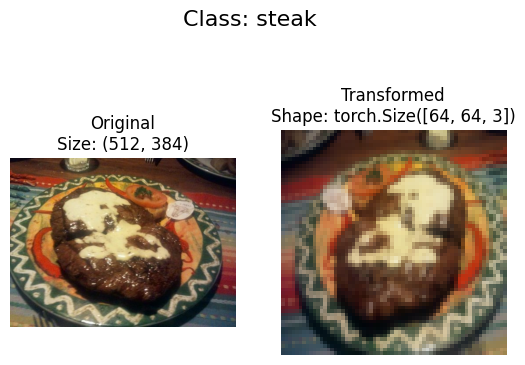

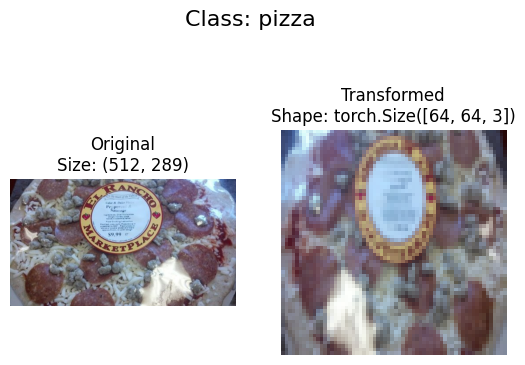

In [35]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):

    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # Transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                            transform=data_transform,
                            n=3,
                            seed=None)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder` - https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder

In [36]:
# Use ImageFolder to create dataset(s)

from torchvision import datasets 

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None # a transform for the label/target 
                                  ) 

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)


train_data, test_data 


(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [37]:
train_dir, test_dir 

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [38]:
# Get class names as list 
class_names = train_data.classes 
class_names 


['pizza', 'steak', 'sushi']

In [39]:
# Get class names as dict 
class_dict = train_data.class_to_idx 
class_dict 

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [40]:
# check the lengths of our dataset 
len(train_data), len(test_data)

(225, 75)

In [42]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)